The shape files for the UK postcode boundaries is provided by http://www.opendoorlogistics.com

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

uk_shape_file = "data/UK-postcode-boundaries-Jan-2015/Districts.shp"
uk = gpd.read_file(uk_shape_file)
uk = uk.to_crs({'init': 'epsg:3395'})
uk['Postcode Area'] = (uk['name'].str.extract('([A-Z]+)', expand=True))

postcode_area_file = "data/Postcode Area.csv"
postcode_area = pd.read_csv(postcode_area_file)

uk = uk.merge(postcode_area, on='Postcode Area')

uk.head()

,name,geometry,Postcode Area,Local Authority Name,Country Name,Region Name,Country_Region
0,AB10,"POLYGON ((-235602.666059466 7754208.69983733, ...",AB,Aberdeen City,Scotland,NaN,Scotland
1,AB11,(POLYGON ((-228491.3918168813 7751689.62609500...,AB,Aberdeen City,Scotland,NaN,Scotland
2,AB12,(POLYGON ((-236895.2592803884 7731770.64912014...,AB,Aberdeen City,Scotland,NaN,Scotland
3,AB13,POLYGON ((-251751.9141073619 7746097.709361252...,AB,Aberdeen City,Scotland,NaN,Scotland
4,AB14,POLYGON ((-251751.9141073615 7746097.709361252...,AB,Aberdeen City,Scotland,NaN,Scotland


In [2]:
training_file = "data/MOT_result_2016_training.csv"

mot_results = pd.read_csv(training_file, parse_dates=['test_date', 'first_use_date'])

mot_results['age'] = (mot_results['test_date'] - mot_results['first_use_date']) / datetime.timedelta(days=365)

# Count PRS (Pass with minor fix with 1 hour) as a Pass
# Reclassify Electric & Hybrid cars as G(reen)
replace_dict = {'test_result':{'PRS':'P'}, 'fuel_type':{'EL':'G', 'FC':'G', 'HY':'G'}}
mot_results = mot_results.replace(replace_dict)

mot_results.head()


,test_id,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date,age
0,635544879,1123718405,2016-01-04,4,NT,F,22263.0,BN,SUZUKI,SWIFT SZ3 DDIS,BLUE,DI,1248.0,2013-09-26,2.273973
1,1135632171,259476332,2016-01-04,4,NT,F,72386.0,WS,PEUGEOT,3008,RED,DI,1560.0,2010-03-02,5.846575
2,1821645967,1196670034,2016-01-03,4,NT,P,58479.0,ME,NISSAN,QASHQAI,BLUE,DI,1461.0,2010-06-28,5.520548
3,727411847,257196698,2016-01-04,4,NT,F,54344.0,BA,VAUXHALL,CORSA,SILVER,PE,1364.0,2007-05-16,8.643836
4,1061185063,1453769504,2016-01-04,4,NT,P,56529.0,PL,MG,ZR,SILVER,PE,1396.0,2005-04-18,10.720548


In [45]:
def calc_rates(summary_filter, column, results_filter="all"):
    if results_filter=="all":
        mot_totals  = mot_results.groupby(['postcode_area', column])[['test_id']].count()
    else:
        mot_totals  = mot_results.query(results_filter).groupby(['postcode_area', column])[['test_id']].count()
    mot_rates = mot_totals.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
    mot_rates = mot_rates.query(summary_filter).rename(columns={'test_id': 'rate'})
    mot_rates = mot_rates.reset_index()
    return mot_rates


def choropleth(ax, mot_data, column, intervals=10, cmap='viridis', region="all"):
    uk_mot = uk.merge(mot_data, left_on='Postcode Area', right_on='postcode_area', how='left')
    if (region != 'all'):
        uk_mot = uk_mot.query('Country_Region=="' + region + '"')
    uk_mot_zero = uk_mot[uk_mot[column].isnull()]
    uk_mot = uk_mot[uk_mot[column].notnull()]
    uk_plot=uk_mot.plot(ax=ax, column=column, scheme='equal_interval', k=intervals, cmap=cmap,
                        legend=False, linewidth=0.1, edgecolor='grey')
    
    if (len(uk_mot_zero) > 0):
        uk_mot_zero.plot(ax=ax, linewidth=0.1, edgecolor='grey', color='white')
    

def colorbar(ax, min_value, max_value, intervals, percent=True, cmap='viridis'):
    interval_width = (max_value - min_value) / intervals

    # Range required for colorbar, color should match midpt of each interval
    levels = np.linspace(min_value + interval_width/2, max_value - interval_width/2, intervals)
    zeros = np.zeros(levels.shape)
    # Dummy plot used to create colorbar
    CS3 = plt.scatter(x=zeros, y=zeros, s=zeros, c=levels, cmap=cmap)
    cbar = plt.colorbar(CS3, cax=ax)
        
    if percent:
        labels = cbar.ax.get_yticklabels()
        format_labels = [l.get_text()+'%' for l in labels]
        cbar.ax.set_yticklabels(format_labels)




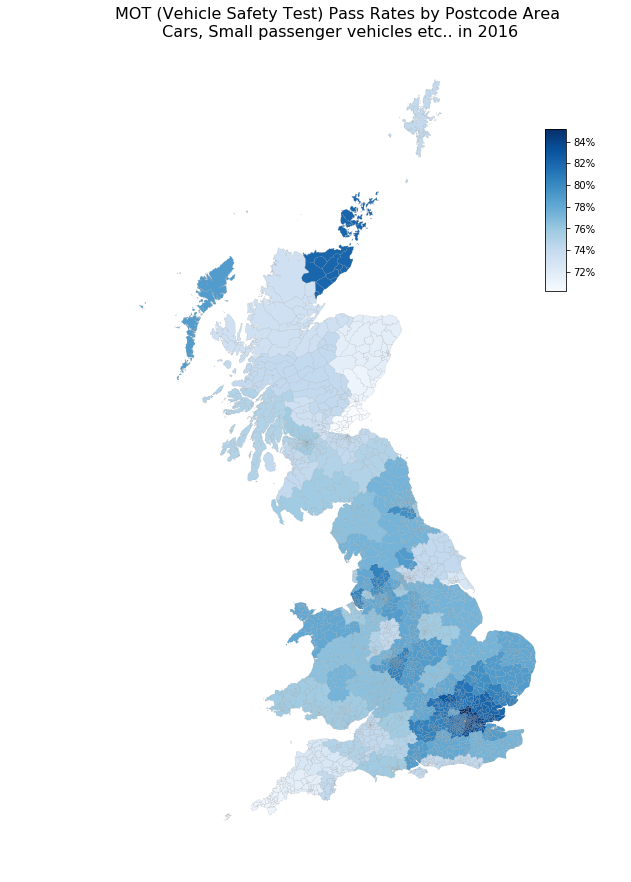

In [25]:
mot_data = calc_rates(summary_filter='test_result=="P"',
            column='test_result'
           )

fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111)
plt.axis('equal')
plt.axis('off')

intervals=20
cmap = 'Blues'

choropleth(ax=ax,
           mot_data=mot_data,
           column='rate',
           intervals=intervals,
           cmap=cmap
           )

plt.title('MOT (Vehicle Safety Test) Pass Rates by Postcode Area\n Cars, Small passenger vehicles etc.. in 2016',
          fontdict={'fontsize':16})

min_value = mot_data['rate'].min()
max_value = mot_data['rate'].max()

# Add axes for colorbar
cbax = fig.add_axes([0.8, 0.65, 0.03, 0.15]) 
# Create colorbar
colorbar(ax=cbax,
         min_value=min_value,
         max_value=max_value,
         intervals=intervals,
         percent=True,
         cmap=cmap
        )

plt.show()

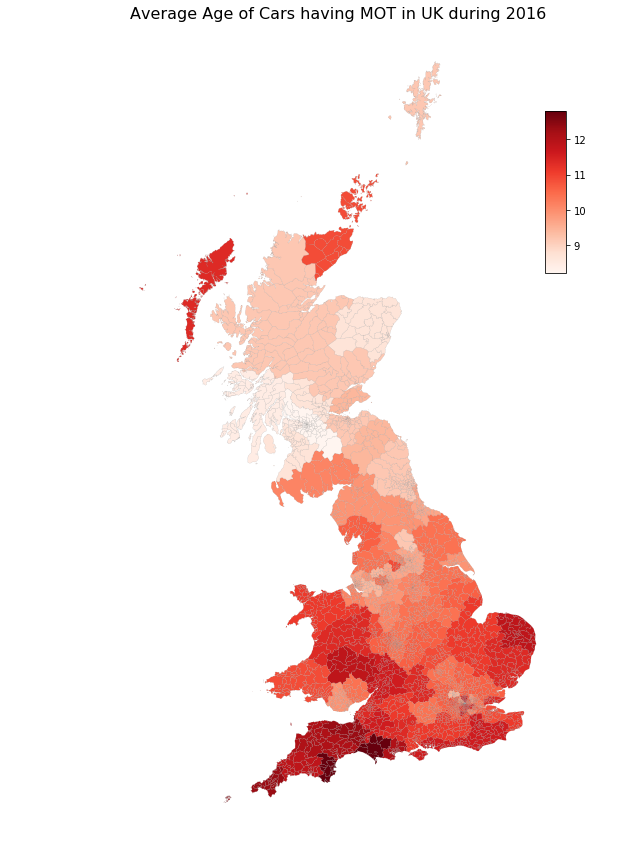

In [23]:
mot_age  = mot_results.groupby('postcode_area')[['age']].mean()
mot_age = mot_age.reset_index()

fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111)
plt.axis('equal')
plt.axis('off')

intervals=20
cmap='Reds'

choropleth(ax=ax,
           mot_data=mot_age,
           column='age',
           intervals=intervals,
           cmap=cmap
           )

plt.title('Average Age of Cars having MOT in UK during 2016',
          fontdict={'fontsize':16})

min_value = mot_age['age'].min()
max_value = mot_age['age'].max()

# Add axes for colorbar
cbax = fig.add_axes([0.8, 0.65, 0.03, 0.15]) 
# Create colorbar
colorbar(ax=cbax,
         min_value=min_value,
         max_value=max_value,
         intervals=intervals,
         percent=False,
         cmap=cmap
        )

plt.show()

In [60]:
from matplotlib.colors import LinearSegmentedColormap

def custom_cmap(min_rate, max_rate, min_scale, max_scale, st_scale, end_scale):
    scale_width = max_scale - min_scale
    min_adj = (min_rate - min_scale) / scale_width
    max_adj = 1.0 - (max_scale - max_rate) / scale_width
    adj_st_scale = [(1-min_adj) * st + min_adj * end for (st,end) in zip(st_scale, end_scale)]
    adj_end_scale = [(1-max_adj) * st + max_adj * end for (st,end) in zip(st_scale, end_scale)]

    cdict = {'red':   ((0.0,  adj_st_scale[0], adj_st_scale[0]),
                       (1.0, adj_end_scale[0], adj_end_scale[0])),

             'green': ((0.0,  adj_st_scale[1], adj_st_scale[1]),
                       (1.0, adj_end_scale[1], adj_end_scale[1])),

             'blue':  ((0.0,  adj_st_scale[2], adj_st_scale[2]),
                       (1.0, adj_end_scale[2], adj_end_scale[2]))}

    # Create the custom color map
    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap

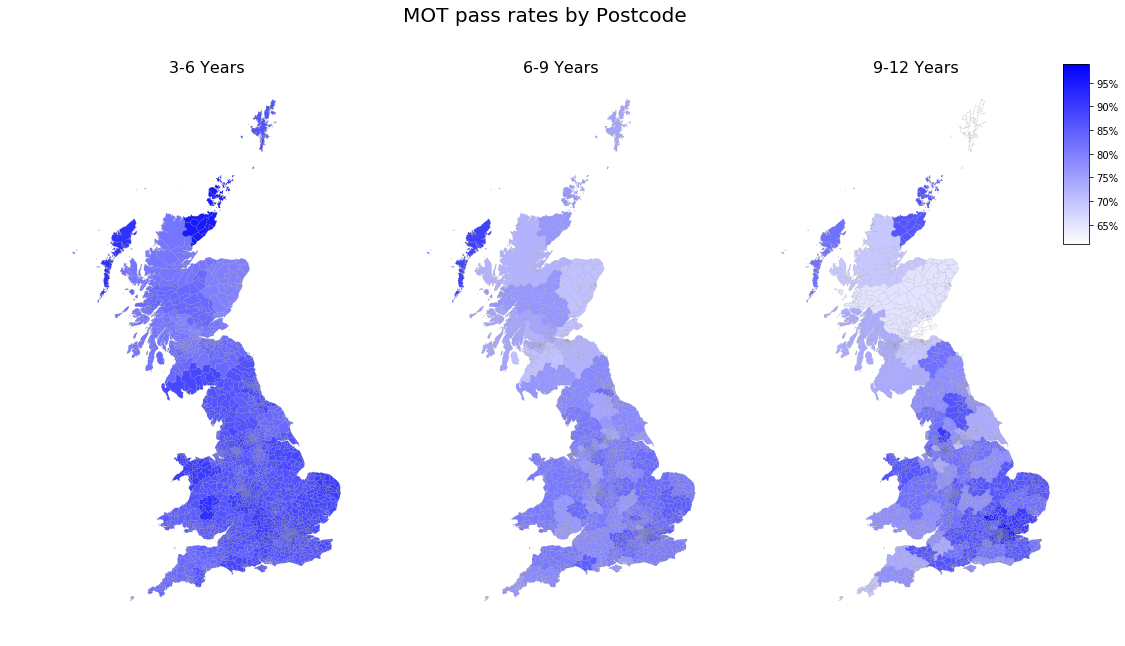

In [59]:
intervals = 20
st_cols = [1,1,1]
end_cols = [0,0,1]
  
fig = plt.figure(figsize=(18,10))
fig.suptitle("MOT pass rates by Postcode", fontsize=20)

mot_data_1 = calc_rates(results_filter="age > 3 and age < 6",
            summary_filter='test_result=="P"',
            column='test_result'
           )

min_rate_1 = mot_data_1['rate'].min()
max_rate_1 = mot_data_1['rate'].max()

mot_data_2 = calc_rates(results_filter="age > 6 and age < 9",
            summary_filter='test_result=="P"',
            column='test_result'
           )

min_rate_2 = mot_data_2['rate'].min()
max_rate_2 = mot_data_2['rate'].max()

mot_data_3 = calc_rates(results_filter="age > 9 and age < 12",
            summary_filter='test_result=="P"',
            column='test_result'
           )

min_rate_3 = mot_data_3['rate'].min()
max_rate_3 = mot_data_3['rate'].max()

# Find common min & max
min_scale = min(min_rate_1, min_rate_2, min_rate_3)
max_scale = max(max_rate_1, max_rate_2, max_rate_3)

def sub_choropleth(mot_data, min_rate, max_rate, location, title):    
    cmap = custom_cmap(min_rate, max_rate, intervals, min_scale, max_scale, st_cols, end_cols)

    ax = fig.add_subplot(location)
    plt.axis('equal')
    plt.axis('off')
    plt.title(title, fontdict={'fontsize':16})

    choropleth(ax=ax,
               mot_data=mot_data,
               column='rate',
               cmap=cmap
               )

# 1st Map
sub_choropleth(mot_data_1, min_rate_1, max_rate_1, 131, '3-6 Years')

# 2nd map
sub_choropleth(mot_data_2, min_rate_2, max_rate_2, 132, '6-9 Years')

# 3rd Map
sub_choropleth(mot_data_3, min_rate_3, max_rate_3, 133, '9-12 Years')

# Color bar. Color scale should be full width
cmap = custom_cmap(min_scale, max_scale, min_scale, max_scale, st_cols, end_cols)
# Add axes for colorbar
cbax = fig.add_axes([0.9, 0.65, 0.02, 0.25]) 
colorbar(cbax, min_scale, max_scale, intervals, percent=True, cmap=cmap)

plt.show()


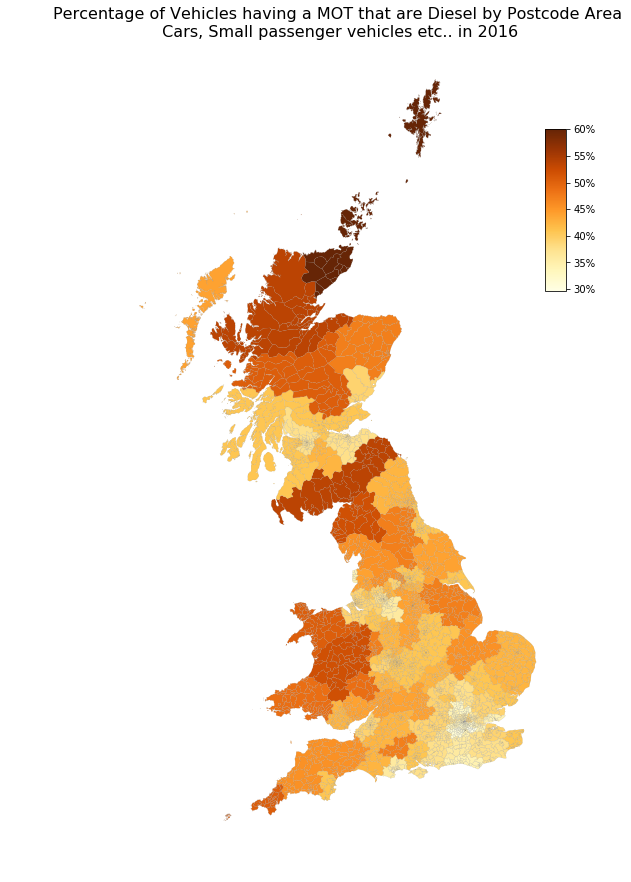

In [20]:
mot_data = calc_rates(summary_filter='fuel_type=="DI"',
            column='fuel_type'
           )

fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(111)
plt.axis('equal')
plt.axis('off')

intervals=20
cmap = 'YlOrBr'

choropleth(ax=ax,
           mot_data=mot_data,
           column='rate',
           intervals=intervals,
           cmap=cmap
           )

plt.title('Percentage of Vehicles having a MOT that are Diesel by Postcode Area\n Cars, Small passenger vehicles etc.. in 2016',
          fontdict={'fontsize':16})

min_value = mot_data['rate'].min()
max_value = mot_data['rate'].max()

# Add axes for colorbar
cbax = fig.add_axes([0.8, 0.65, 0.03, 0.15]) 
# Create colorbar
colorbar(ax=cbax,
         min_value=min_value,
         max_value=max_value,
         intervals=intervals,
         percent=True,
         cmap=cmap
        )

plt.show()

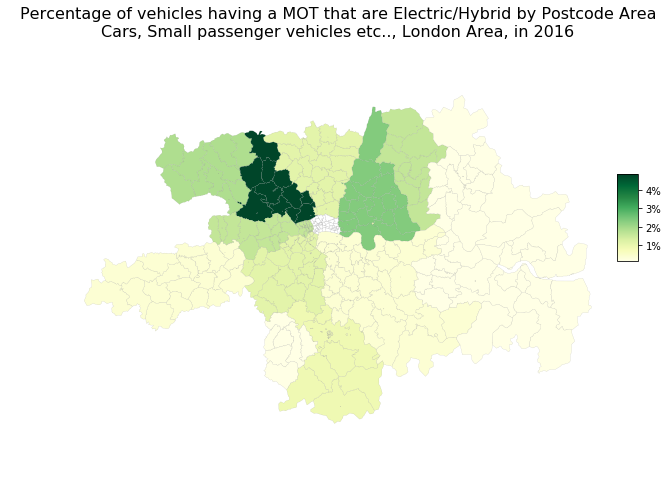

In [62]:
mot_data = calc_rates(summary_filter='fuel_type=="G"',
            column='fuel_type'
           )

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.axis('equal')
plt.axis('off')

intervals=20
cmap = 'YlGn'

choropleth(ax=ax,
           mot_data=mot_data,
           column='rate',
           region='London',
           intervals=intervals,
           cmap=cmap
           )

plt.title('''Percentage of vehicles having a MOT that are Electric/Hybrid by Postcode Area
Cars, Small passenger vehicles etc.., London Area, in 2016''',
          fontdict={'fontsize':16})

min_value = mot_data['rate'].min()
max_value = mot_data['rate'].max()

# Add axes for colorbar
cbax = fig.add_axes([0.9,0.5, 0.03, 0.15]) 
# Create colorbar
colorbar(ax=cbax,
         min_value=min_value,
         max_value=max_value,
         intervals=intervals,
         percent=True,
         cmap=cmap
        )

plt.show()